<a href="https://colab.research.google.com/github/amagri16/mase/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/DeepWok/mase.git

Cloning into 'mase'...
remote: Enumerating objects: 26753, done.
remote: Counting objects: 100% (3748/3748), done.
remote: Compressing objects: 100% (568/568), done.
remote: Total 26753 (delta 3410), reused 3196 (delta 3179), pack-reused 23005 (from 3)
Receiving objects: 100% (26753/26753), 114.84 MiB | 23.71 MiB/s, done.
Resolving deltas: 100% (17103/17103), done.


In [3]:
%cd mase

/content/mase


In [4]:
!pip install -e . -vvv

Output streaming troncato alle ultime 5000 righe.
  Skipping link: none of the wheel's tags (cp310-cp310-musllinux_1_1_x86_64) are compatible (run pip debug --verbose to show compatible tags): https://files.pythonhosted.org/packages/46/09/941c11c98d56758eb13e5da0f451f00a051072c751fff3e191bf4723b1d7/coverage-6.4-cp310-cp310-musllinux_1_1_x86_64.whl (from https://pypi.org/simple/coverage/) (requires-python:>=3.7)
  Skipping link: none of the wheel's tags (cp310-cp310-win32) are compatible (run pip debug --verbose to show compatible tags): https://files.pythonhosted.org/packages/d3/5b/fe12a83e9671cb9c5a7c9e623735c121cd80ca1e049fd049b371dd704f4f/coverage-6.4-cp310-cp310-win32.whl (from https://pypi.org/simple/coverage/) (requires-python:>=3.7)
  Skipping link: none of the wheel's tags (cp310-cp310-win_amd64) are compatible (run pip debug --verbose to show compatible tags): https://files.pythonhosted.org/packages/d8/e8/dd4a92c84359e6c5647de9245a7210eba015d919e8e14be8a7b485850805/coverage-6.

In [1]:
!python -c "import chop"

2025-02-11 23:21:10.280034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739316070.539746    6713 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739316070.612680    6713 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 23:21:11.168702: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import torch.nn as nn
from chop.nn.modules import Identity
from transformers import AutoConfig, AutoModelForSequenceClassification
from chop.tools.utils import deepsetattr
from chop.tools import get_tokenized_dataset, get_trainer
import optuna
from optuna.samplers import GridSampler, TPESampler, RandomSampler
import matplotlib.pyplot as plt
import dill
import pandas as pd

# -----------------------------
# 1. Define your checkpoints & dataset
# -----------------------------
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

# Load tokenized dataset and tokenizer
dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

# -----------------------------
# 2. Define search space
# -----------------------------
grid_search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": [
        nn.Linear,
        Identity,
    ],
}

tpe_search_space = grid_search_space  # Using the same search space for consistency

# -----------------------------
# 3. Construct the model given a trial
# -----------------------------
def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)

    # Map trial parameters to BERT config
    config.num_hidden_layers = trial.suggest_categorical(
        "num_layers", tpe_search_space["num_layers"]
    )
    config.num_attention_heads = trial.suggest_categorical(
        "num_heads", tpe_search_space["num_heads"]
    )
    config.hidden_size = trial.suggest_categorical(
        "hidden_size", tpe_search_space["hidden_size"]
    )
    config.intermediate_size = trial.suggest_categorical(
        "intermediate_size", tpe_search_space["intermediate_size"]
    )

    model = AutoModelForSequenceClassification.from_config(config)

    # Handle linear layer choice
    linear_choice = trial.suggest_categorical(
        "linear_layer_choices", tpe_search_space["linear_layer_choices"]
    )

    if linear_choice == "identity":
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
                deepsetattr(model, name, Identity())

    return model

# -----------------------------
# 4. Define the objective function
# -----------------------------
def objective(trial):
    try:
        trial_model = construct_model(trial)

        trainer = get_trainer(
            model=trial_model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=1,   # Reduced for demonstration
        )

        trainer.train()
        eval_results = trainer.evaluate()

        # Save the trial configuration and accuracy for logging
        trial.set_user_attr("model", trial_model)
        trial.set_user_attr("accuracy", eval_results["eval_accuracy"])
        trial.set_user_attr("params", trial.params)

        return eval_results["eval_accuracy"]
    except Exception as e:
        print(f"Trial failed: {e}")
        return None

# -----------------------------
# 5. Helper to run a study and log results to CSV
# -----------------------------
def run_study_and_log_results(sampler, n_trials, study_name="study"):
    study = optuna.create_study(
        direction="maximize",
        study_name=study_name,
        sampler=sampler,
    )

    study.optimize(
        objective,
        n_trials=n_trials,
        timeout=60 * 10 * 24,
        show_progress_bar=False,
    )

    # Save trial results to a CSV file
    trial_results = []
    for trial in study.trials:
        trial_results.append({
            "trial_number": trial.number,
            "accuracy": trial.value,
            **trial.params,  # Include all parameter values
        })

    # Convert to DataFrame and save
    df = pd.DataFrame(trial_results)
    csv_filename = f"{study_name}_results.csv"
    df.to_csv(csv_filename, index=False)
    print(f"Results saved to {csv_filename}")

    return study, trial_results

# -----------------------------
# 6. Compare GridSampler, TPESampler, and RandomSampler
# -----------------------------
if __name__ == "__main__":
    # Define samplers
    grid_sampler = GridSampler(
        search_space={
            "num_layers": grid_search_space["num_layers"],
            "num_heads": grid_search_space["num_heads"],
            "hidden_size": grid_search_space["hidden_size"],
            "intermediate_size": grid_search_space["intermediate_size"],
            "linear_layer_choices": grid_search_space["linear_layer_choices"],
        }
    )
    tpe_sampler = TPESampler()
    random_sampler = RandomSampler()

    # Run experiments
    n_trials = 20

    # Run GridSampler study and log results
    grid_study, grid_results = run_study_and_log_results(
        sampler=grid_sampler,
        n_trials=n_trials,
        study_name="bert-grid-study"
    )
    print(f"[GridSampler] Best accuracy: {grid_study.best_value:.4f}")

    # Run TPESampler study and log results
    tpe_study, tpe_results = run_study_and_log_results(
        sampler=tpe_sampler,
        n_trials=n_trials,
        study_name="bert-tpe-study"
    )
    print(f"[TPESampler] Best accuracy: {tpe_study.best_value:.4f}")

    # Run RandomSampler study and log results
    random_study, random_results = run_study_and_log_results(
        sampler=random_sampler,
        n_trials=n_trials,
        study_name="bert-random-study"
    )
    print(f"[RandomSampler] Best accuracy: {random_study.best_value:.4f}")

    # -----------------------------
    # 7. Plot the results
    # -----------------------------
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(grid_results)+1), [r["accuracy"] for r in grid_results], label="GridSampler", marker="o")
    plt.plot(range(1, len(tpe_results)+1), [r["accuracy"] for r in tpe_results], label="TPESampler", marker="x")
    plt.plot(range(1, len(random_results)+1), [r["accuracy"] for r in random_results], label="RandomSampler", marker="s")
    plt.xlabel("Number of Trials")
    plt.ylabel("Max Accuracy So Far")
    plt.title("Comparison of Samplers")
    plt.legend()
    plt.grid()
    plt.show()

    # -----------------------------
    # 8. Save the best models and configurations
    # -----------------------------
    best_grid_model = grid_study.best_trial.user_attrs["model"].cpu()
    best_grid_params = grid_study.best_trial.user_attrs["params"]
    with open("best_grid_model.pkl", "wb") as f:
        dill.dump(best_grid_model, f)
    with open("best_grid_config.txt", "w") as f:
        f.write(str(best_grid_params))

    best_tpe_model = tpe_study.best_trial.user_attrs["model"].cpu()
    best_tpe_params = tpe_study.best_trial.user_attrs["params"]
    with open("best_tpe_model.pkl", "wb") as f:
        dill.dump(best_tpe_model, f)
    with open("best_tpe_config.txt", "w") as f:
        f.write(str(best_tpe_params))

    best_random_model = random_study.best_trial.user_attrs["model"].cpu()
    best_random_params = random_study.best_trial.user_attrs["params"]
    with open("best_random_model.pkl", "wb") as f:
        dill.dump(best_random_model, f)
    with open("best_random_config.txt", "w") as f:
        f.write(str(best_random_params))


INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

[I 2025-02-11 23:23:38,673] A new study created in memory with name: bert-tiny-nas-baseline-tpe


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

num_layers: Chosen index = 1, Chosen value = 4
num_heads: Chosen index = 2, Chosen value = 8
hidden_size: Chosen index = 3, Chosen value = 384
intermediate_size: Chosen index = 2, Chosen value = 1024


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.700300
1000,0.623300
1500,0.486200
2000,0.428000
2500,0.400100
3000,0.396200


[I 2025-02-11 23:26:15,169] Trial 0 finished with value: 0.84484 and parameters: {'num_layers': 1, 'num_heads': 2, 'hidden_size': 3, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 0 with

num_layers: Chosen index = 1, Chosen value = 4
num_heads: Chosen index = 3, Chosen value = 16
hidden_size: Chosen index = 0, Chosen value = 128
intermediate_size: Chosen index = 3, Chosen value = 1536


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693600
1000,0.632200
1500,0.502700
2000,0.453100
2500,0.422300
3000,0.418100


[I 2025-02-11 23:27:52,584] Trial 1 finished with value: 0.83224 and parameters: {'num_layers': 1, 'num_heads': 3, 'hidden_size': 0, 'intermediate_size': 3, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 0 with

num_layers: Chosen index = 2, Chosen value = 8
num_heads: Chosen index = 2, Chosen value = 8
hidden_size: Chosen index = 1, Chosen value = 192
intermediate_size: Chosen index = 0, Chosen value = 512


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.691200
1000,0.534700
1500,0.429000
2000,0.374200
2500,0.337300
3000,0.353000


[I 2025-02-11 23:29:40,920] Trial 2 finished with value: 0.85272 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 1, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 2 with value: 0.85

num_layers: Chosen index = 2, Chosen value = 8
num_heads: Chosen index = 0, Chosen value = 2
hidden_size: Chosen index = 4, Chosen value = 512
intermediate_size: Chosen index = 0, Chosen value = 512


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.644300
1000,0.472500
1500,0.415400
2000,0.381900
2500,0.333900
3000,0.331800


[I 2025-02-11 23:32:40,609] Trial 3 finished with value: 0.86368 and parameters: {'num_layers': 2, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1

num_layers: Chosen index = 1, Chosen value = 4
num_heads: Chosen index = 0, Chosen value = 2
hidden_size: Chosen index = 4, Chosen value = 512
intermediate_size: Chosen index = 0, Chosen value = 512


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.639800
1000,0.484700
1500,0.401100
2000,0.364500
2500,0.325500
3000,0.338600


[I 2025-02-11 23:35:44,264] Trial 4 finished with value: 0.86268 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.l

num_layers: Chosen index = 0, Chosen value = 2
num_heads: Chosen index = 1, Chosen value = 4
hidden_size: Chosen index = 3, Chosen value = 384
intermediate_size: Chosen index = 1, Chosen value = 768


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.669200
1000,0.491200
1500,0.431000
2000,0.388300
2500,0.349200
3000,0.345400


[I 2025-02-11 23:38:20,201] Trial 5 finished with value: 0.85456 and parameters: {'num_layers': 0, 'num_heads': 1, 'hidden_size': 3, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 3 with va

num_layers: Chosen index = 2, Chosen value = 8
num_heads: Chosen index = 3, Chosen value = 16
hidden_size: Chosen index = 0, Chosen value = 128
intermediate_size: Chosen index = 4, Chosen value = 2048


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693800
1000,0.651000
1500,0.528500
2000,0.448000
2500,0.398000
3000,0.398700


[I 2025-02-11 23:40:05,114] Trial 6 finished with value: 0.83876 and parameters: {'num_layers': 2, 'num_heads': 3, 'hidden_size': 0, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 3 with value

num_layers: Chosen index = 1, Chosen value = 4
num_heads: Chosen index = 0, Chosen value = 2
hidden_size: Chosen index = 0, Chosen value = 128
intermediate_size: Chosen index = 0, Chosen value = 512


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693400
1000,0.625500
1500,0.470800
2000,0.420500
2500,0.384500
3000,0.387500


[I 2025-02-11 23:41:35,435] Trial 7 finished with value: 0.84088 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 0, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 3 with value: 0

num_layers: Chosen index = 0, Chosen value = 2
num_heads: Chosen index = 3, Chosen value = 16
hidden_size: Chosen index = 3, Chosen value = 384
intermediate_size: Chosen index = 2, Chosen value = 1024


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.665800
1000,0.537900
1500,0.477700
2000,0.428000
2500,0.379100
3000,0.373700


[I 2025-02-11 23:44:16,432] Trial 8 finished with value: 0.84772 and parameters: {'num_layers': 0, 'num_heads': 3, 'hidden_size': 3, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 3 with va

num_layers: Chosen index = 0, Chosen value = 2
num_heads: Chosen index = 3, Chosen value = 16
hidden_size: Chosen index = 1, Chosen value = 192
intermediate_size: Chosen index = 1, Chosen value = 768


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.696200
1000,0.621000
1500,0.481200
2000,0.420000
2500,0.377300
3000,0.386600


[I 2025-02-11 23:46:06,053] Trial 9 finished with value: 0.83856 and parameters: {'num_layers': 0, 'num_heads': 3, 'hidden_size': 1, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 3 with va

num_layers: Chosen index = 1, Chosen value = 4
num_heads: Chosen index = 2, Chosen value = 8
hidden_size: Chosen index = 0, Chosen value = 128
intermediate_size: Chosen index = 1, Chosen value = 768


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.689400
1000,0.633300
1500,0.487900
2000,0.438800
2500,0.413900
3000,0.413500


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[[[-0.1523,  0.7589,  1.3673,  ..., -0.4916, -0.4271,  1.2963],
          [ 0.3152, -0.4069,  0.7962,  ...,  0.2513,  0.6434, -0.5340]],

         [[ 0.9171,  1.5787,  0.0799,  ..., -0.4993,  0.4095,  0.6000],
          [ 1.1007, -1.5746,  1.5827,  ...,  0.4407,  1.4540, -0.1939]],

         [[-0.0044,  1.7508,  0.2162,  ..., -0.3911,  0.1454,  0.9493],
          [ 1.8884, -0.6068,  0.4418,  ..., -0.1875,  2.2254,  1.2437]],

         ...,

         [[ 0.2915,  1.2792,  0.5071,  ..., -0.9178, -0.9015,  0.7585],
          [ 2.1905, -1.2895,  1.1562,  ..., -1.3329,  1.5661, -0.0560]],

         [[ 1.2033,  0.9852,  0.3220,  ..., -0.9833,  0.3967,  0.1233],
          [ 1.6633, -0.7114,  1.3374,  ...,  0.0301,  1.4433, -0.4721]],

         [[ 0.7678,  1.1943,  0.0148,  ..., -1.3760, -0.2390, -0.0309],
          [ 0.4708, -1.0505,  0.8758,  ..., -0.7522,  2.3772, -0.7186]]],


        [[[ 0.9529,  0.4923,  1.1895,  ..., -0.7652, -0.8482,  2.0350],
          [-0.3483, -0.7210,  0.362

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-02-11 23:47:56,957] Trial 0 finished with value: 0.53992 and parameters: {'num_layers': 1, 'num_heads': 2, 'hidden_size': 0, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 

num_layers: Chosen index = 0, Chosen value = 2
num_heads: Chosen index = 2, Chosen value = 8
hidden_size: Chosen index = 4, Chosen value = 512
intermediate_size: Chosen index = 4, Chosen value = 2048


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.670700
1000,0.488700
1500,0.415800
2000,0.371300
2500,0.342100
3000,0.347700


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-02-11 23:53:36,835] Trial 1 finished with value: 0.5706 and parameters: {'num_layers': 0, 'num_heads': 2, 'hidden_size': 4, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 1 with val

num_layers: Chosen index = 0, Chosen value = 2
num_heads: Chosen index = 1, Chosen value = 4
hidden_size: Chosen index = 4, Chosen value = 512
intermediate_size: Chosen index = 1, Chosen value = 768


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.650100
1000,0.471900
1500,0.430200
2000,0.383500
2500,0.352900
3000,0.350000


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-02-11 23:57:50,178] Trial 2 finished with value: 0.5574 and parameters: {'num_layers': 0, 'num_heads': 1, 'hidden_size': 4, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 1 with val

num_layers: Chosen index = 1, Chosen value = 4
num_heads: Chosen index = 2, Chosen value = 8
hidden_size: Chosen index = 4, Chosen value = 512
intermediate_size: Chosen index = 2, Chosen value = 1024


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.656200
1000,0.494500
1500,0.431900
2000,0.400900
2500,0.357600
3000,0.336600


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-02-12 00:02:46,657] Trial 3 finished with value: 0.62308 and parameters: {'num_layers': 1, 'num_heads': 2, 'hidden_size': 4, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 3 with value: 0

num_layers: Chosen index = 1, Chosen value = 4
num_heads: Chosen index = 2, Chosen value = 8
hidden_size: Chosen index = 0, Chosen value = 128
intermediate_size: Chosen index = 4, Chosen value = 2048


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.695400
1000,0.615000
1500,0.477500
2000,0.404600
2500,0.375700
3000,0.387600


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Pruning module: bert_encoder_layer_0_attention_self_key


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-02-12 00:05:29,229] Trial 4 finished with value: 0.76448 and parameters: {'num_layers': 1, 'num_heads': 2, 'hidden_size': 0, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 4 with va

num_layers: Chosen index = 0, Chosen value = 2
num_heads: Chosen index = 0, Chosen value = 2
hidden_size: Chosen index = 4, Chosen value = 512
intermediate_size: Chosen index = 3, Chosen value = 1536


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.662000
1000,0.533000
1500,0.500700
2000,0.471500
2500,0.433700
3000,0.401500


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-02-12 00:10:09,735] Trial 5 finished with value: 0.61792 and parameters: {'num_layers': 0, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 3, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 4 w

num_layers: Chosen index = 1, Chosen value = 4
num_heads: Chosen index = 0, Chosen value = 2
hidden_size: Chosen index = 4, Chosen value = 512
intermediate_size: Chosen index = 1, Chosen value = 768


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.652900
1000,0.529300
1500,0.495200
2000,0.465500
2500,0.421200
3000,0.415300


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-02-12 00:14:24,277] Trial 6 finished with value: 0.643 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 4 with value: 

num_layers: Chosen index = 0, Chosen value = 2
num_heads: Chosen index = 2, Chosen value = 8
hidden_size: Chosen index = 0, Chosen value = 128
intermediate_size: Chosen index = 2, Chosen value = 1024


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693300
1000,0.621500
1500,0.475100
2000,0.427200
2500,0.384800
3000,0.388100


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-02-12 00:16:31,053] Trial 7 finished with value: 0.7602 and parameters: {'num_layers': 0, 'num_heads': 2, 'hidden_size': 0, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 4 with val

num_layers: Chosen index = 2, Chosen value = 8
num_heads: Chosen index = 1, Chosen value = 4
hidden_size: Chosen index = 0, Chosen value = 128
intermediate_size: Chosen index = 1, Chosen value = 768


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.687100
1000,0.584300
1500,0.457600
2000,0.399600
2500,0.373800
3000,0.375400


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-02-12 00:18:28,303] Trial 8 finished with value: 0.59652 and parameters: {'num_layers': 2, 'num_heads': 1, 'hidden_size': 0, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 4 with

num_layers: Chosen index = 1, Chosen value = 4
num_heads: Chosen index = 3, Chosen value = 16
hidden_size: Chosen index = 4, Chosen value = 512
intermediate_size: Chosen index = 2, Chosen value = 1024


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.644300
1000,0.480500
1500,0.414800
2000,0.364100
2500,0.342900
3000,0.355400


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[I 2025-02-12 00:23:01,576] Trial 9 finished with value: 0.598 and parameters: {'num_layers': 1, 'num_heads': 3, 'hidden_size': 4, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 4 with value: 

num_layers: Chosen index = 1, Chosen value = 4
num_heads: Chosen index = 0, Chosen value = 2
hidden_size: Chosen index = 2, Chosen value = 256
intermediate_size: Chosen index = 2, Chosen value = 1024


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.681500
1000,0.564700
1500,0.473700
2000,0.430200
2500,0.393400
3000,0.393000


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.413200
1000,0.338700
1500,0.326100
2000,0.322700
2500,0.319500
3000,0.344800


[I 2025-02-12 00:28:24,422] Trial 0 finished with value: 0.861 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 2, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 0 with value: 0.8

num_layers: Chosen index = 1, Chosen value = 4
num_heads: Chosen index = 0, Chosen value = 2
hidden_size: Chosen index = 0, Chosen value = 128
intermediate_size: Chosen index = 2, Chosen value = 1024


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694200
1000,0.654000
1500,0.493800
2000,0.437800
2500,0.386000
3000,0.392200


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.420200
1000,0.328700
1500,0.322500
2000,0.321400
2500,0.313500
3000,0.345200


[I 2025-02-12 00:32:30,176] Trial 1 finished with value: 0.8612 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 0, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 1 with value: 0.861

num_layers: Chosen index = 1, Chosen value = 4
num_heads: Chosen index = 1, Chosen value = 4
hidden_size: Chosen index = 2, Chosen value = 256
intermediate_size: Chosen index = 3, Chosen value = 1536


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.687400
1000,0.508900
1500,0.435500
2000,0.387600
2500,0.349500
3000,0.357900


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.404700
1000,0.318700
1500,0.317000
2000,0.311400
2500,0.312600
3000,0.329400


[I 2025-02-12 00:38:46,094] Trial 2 finished with value: 0.86436 and parameters: {'num_layers': 1, 'num_heads': 1, 'hidden_size': 2, 'intermediate_size': 3, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 2 with value: 0

num_layers: Chosen index = 1, Chosen value = 4
num_heads: Chosen index = 0, Chosen value = 2
hidden_size: Chosen index = 4, Chosen value = 512
intermediate_size: Chosen index = 2, Chosen value = 1024


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.656200
1000,0.466000
1500,0.394600
2000,0.349600
2500,0.320200
3000,0.346600


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.352300
1000,0.280300
1500,0.277200
2000,0.281300
2500,0.280200
3000,0.306000


[I 2025-02-12 00:48:33,418] Trial 3 finished with value: 0.87212 and parameters: {'num_layers': 1, 'num_heads': 0, 'hidden_size': 4, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 3 with value: 0.87

num_layers: Chosen index = 2, Chosen value = 8
num_heads: Chosen index = 0, Chosen value = 2
hidden_size: Chosen index = 1, Chosen value = 192
intermediate_size: Chosen index = 0, Chosen value = 512


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.690700
1000,0.570100
1500,0.439800
2000,0.391200
2500,0.368600
3000,0.364700


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.414500
1000,0.323800
1500,0.321600
2000,0.316800
2500,0.316600
3000,0.354000


[I 2025-02-12 00:52:35,788] Trial 4 finished with value: 0.86652 and parameters: {'num_layers': 2, 'num_heads': 0, 'hidden_size': 1, 'intermediate_size': 0, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 3 with value

num_layers: Chosen index = 0, Chosen value = 2
num_heads: Chosen index = 3, Chosen value = 16
hidden_size: Chosen index = 2, Chosen value = 256
intermediate_size: Chosen index = 2, Chosen value = 1024


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.682500
1000,0.523700
1500,0.425800
2000,0.382400
2500,0.341900
3000,0.355500


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.394100
1000,0.322100
1500,0.309400
2000,0.310600
2500,0.296200
3000,0.344200


[I 2025-02-12 00:57:46,487] Trial 5 finished with value: 0.86732 and parameters: {'num_layers': 0, 'num_heads': 3, 'hidden_size': 2, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 3 with va

num_layers: Chosen index = 0, Chosen value = 2
num_heads: Chosen index = 1, Chosen value = 4
hidden_size: Chosen index = 2, Chosen value = 256
intermediate_size: Chosen index = 2, Chosen value = 1024


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.686700
1000,0.549700
1500,0.473400
2000,0.420200
2500,0.371600
3000,0.356300


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.457800
1000,0.357600
1500,0.351900
2000,0.316700
2500,0.325100
3000,0.334700


[I 2025-02-12 01:03:07,016] Trial 6 finished with value: 0.85736 and parameters: {'num_layers': 0, 'num_heads': 1, 'hidden_size': 2, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 3 with value

num_layers: Chosen index = 0, Chosen value = 2
num_heads: Chosen index = 0, Chosen value = 2
hidden_size: Chosen index = 0, Chosen value = 128
intermediate_size: Chosen index = 1, Chosen value = 768


/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.691800
1000,0.625100
1500,0.463300
2000,0.411000
2500,0.381300
3000,0.383300


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.428100
1000,0.333500
1500,0.327200
2000,0.322200
2500,0.321800
3000,0.349500


[I 2025-02-12 01:06:46,513] Trial 7 finished with value: 0.86196 and parameters: {'num_layers': 0, 'num_heads': 0, 'hidden_size': 0, 'intermediate_size': 1, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 3 with va

num_layers: Chosen index = 2, Chosen value = 8
num_heads: Chosen index = 3, Chosen value = 16
hidden_size: Chosen index = 2, Chosen value = 256
intermediate_size: Chosen index = 4, Chosen value = 2048


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693100
1000,0.546500
1500,0.441700
2000,0.391300
2500,0.364300
3000,0.358300


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.419200
1000,0.327300
1500,0.318800
2000,0.317000
2500,0.314200
3000,0.329100


[I 2025-02-12 01:13:05,952] Trial 8 finished with value: 0.8578 and parameters: {'num_layers': 2, 'num_heads': 3, 'hidden_size': 2, 'intermediate_size': 4, 'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.pooler.dense_type': <class 'torch.nn.modules.linear.Linear'>}. Best is trial 3 with 

num_layers: Chosen index = 2, Chosen value = 8
num_heads: Chosen index = 2, Chosen value = 8
hidden_size: Chosen index = 2, Chosen value = 256
intermediate_size: Chosen index = 2, Chosen value = 1024


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.modules.identity.Identity'> which is of type type.
  warnings.warn(message)
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.682500
1000,0.525200
1500,0.436000
2000,0.394000
2500,0.351700
3000,0.359500


`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]])
tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
   

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: classifier
/content/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.398700
1000,0.316900
1500,0.311200
2000,0.311500
2500,0.304000
3000,0.338200


[I 2025-02-12 01:18:15,486] Trial 9 finished with value: 0.8672 and parameters: {'num_layers': 2, 'num_heads': 2, 'hidden_size': 2, 'intermediate_size': 2, 'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'chop.nn.modules.identity.Identity'>, 'bert.encoder.layer.1.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.pooler.dense_type': <class 'chop.nn.modules.identity.Identity'>}. Best is trial 3 with val

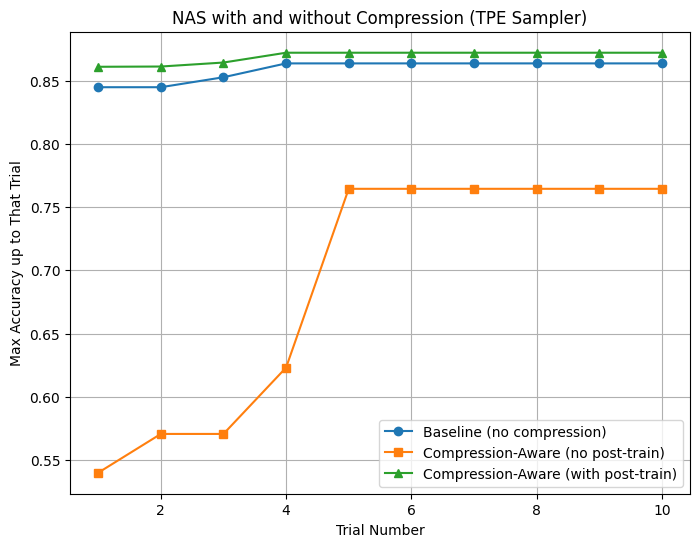

In [2]:
import optuna
from optuna.samplers import TPESampler

import torch.nn as nn
import matplotlib.pyplot as plt

from transformers import AutoConfig, AutoModelForSequenceClassification

import pandas as pd

def save_study_results_to_csv(study, filename):
    trials_data = []
    for trial in study.get_trials(deepcopy=False):
        trials_data.append({
            "trial_number": trial.number,
            "value": trial.value,
            "params": trial.params,
            "user_attrs": trial.user_attrs,
        })
    # Convert the trials data to a DataFrame
    df = pd.DataFrame(trials_data)
    # Save to CSV
    df.to_csv(filename, index=False)

# ---------------------------
# 1) PREPARE DATA + TRAINER
# ---------------------------
# MASE helpers
from chop.tools import get_tokenized_dataset, get_trainer, deepsetattr
from chop.pipelines import CompressionPipeline
from chop import MaseGraph
from chop.nn.modules import Identity


# For demonstration:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

# ---------------------------
# 2) DEFINE SEARCH SPACE
# ---------------------------
search_space = {
    "num_layers": [2, 4, 8],
    "num_heads": [2, 4, 8, 16],
    "hidden_size": [128, 192, 256, 384, 512],
    "intermediate_size": [512, 768, 1024, 1536, 2048],
    "linear_layer_choices": [
        nn.Linear,
        Identity,
    ],
}

def construct_model(trial):
    config = AutoConfig.from_pretrained(checkpoint)

    # Update the paramaters in the config
    for param in [
        "num_layers",
        "num_heads",
        "hidden_size",
        "intermediate_size",
    ]:
        chosen_idx = trial.suggest_int(param, 0, len(search_space[param]) - 1)
        chosen_value = search_space[param][chosen_idx]
        setattr(config, param, chosen_value)  # Set the actual value in the config

        print(f"{param}: Chosen index = {chosen_idx}, Chosen value = {chosen_value}")


    trial_model = AutoModelForSequenceClassification.from_config(config)

    for name, layer in trial_model.named_modules():
        if isinstance(layer, nn.Linear) and layer.in_features == layer.out_features:
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == nn.Linear:
                continue
            elif new_layer_cls == Identity:
                new_layer = Identity()
                deepsetattr(trial_model, name, new_layer)
            else:
                raise ValueError(f"Unknown layer type: {new_layer_cls}")

    return trial_model


# ---------------------------
# 3) BASELINE (NO COMPRESSION)
# ---------------------------
def objective_baseline(trial):
    """
    Standard objective: train for a short time and return accuracy.
    """
    model = construct_model(trial)
    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,  # 1 epoch for demonstration
    )
    trainer.train()
    eval_results = trainer.evaluate()
    final_acc = eval_results["eval_accuracy"]

    # Store model if you want to retrieve it later
    trial.set_user_attr("model", model)
    return final_acc

# Create + run the baseline study
study_baseline = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-baseline-tpe",
    sampler=TPESampler(seed=0),
)
study_baseline.optimize(
    objective_baseline,
    n_trials=10,
    timeout=60*30*24,
)

# Compute running "best so far" for baseline
trials_baseline = study_baseline.get_trials(deepcopy=False)
best_so_far_baseline = []
current_max = float("-inf")
for t in trials_baseline:
    if t.value is not None:
        current_max = max(current_max, t.value)
    best_so_far_baseline.append(current_max)

# Save baseline study results
save_study_results_to_csv(study_baseline, "baseline_study_results.csv")



# ---------------------------
# 4) COMPRESSION‐AWARE (NO POST‐TRAIN)
# ---------------------------


# A small wrapper so the pruned/quantized MaseGraph can be used in a trainer
class HuggingFaceCompatibleModel(nn.Module):
    def __init__(self, compressed_model):
        super().__init__()
        self.compressed_model = compressed_model

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.compressed_model(input_ids=input_ids)
        logits = outputs["logits"] if isinstance(outputs, dict) else outputs
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
        return {"loss": loss, "logits": logits}

def objective_compress_no_post(trial):

    quantization_config = {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": 8,
                "data_in_frac_width": 4,
                # weight
                "weight_width": 8,
                "weight_frac_width": 4,
                # bias
                "bias_width": 8,
                "bias_frac_width": 4,
            }
        },
    }

    pruning_config = {
        "weight": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
        "activation": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
    }

    """
    1) Build model + partial train
    2) Compress (quantize & prune)
    3) Evaluate compressed model with NO further training
    """
    # 1) Build + partial train
    model = construct_model(trial)
    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    trainer.train()

    model.to("cpu")

    # 2) Compress
    mg = MaseGraph(model)
    pipe = CompressionPipeline()
    mg, _ = pipe(
        mg,
        pass_args={
            "quantize_transform_pass": quantization_config,
            "prune_transform_pass": pruning_config,
        },
    )

    # 3) Evaluate after compression
    mg.model.to("cuda")
    wrapped_model = HuggingFaceCompatibleModel(mg.model).to("cuda")

    trainer_eval = get_trainer(
        model=wrapped_model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=0,
    )
    eval_results = trainer_eval.evaluate()
    final_acc = eval_results["eval_accuracy"]

    trial.set_user_attr("model", wrapped_model)
    return final_acc

study_compress_no_post = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-compression-no-post",
    sampler=TPESampler(seed=1),
)
study_compress_no_post.optimize(
    objective_compress_no_post,
    n_trials=10,
    timeout=60*30*12,
)

# Compute running "best so far"
trials_no_post = study_compress_no_post.get_trials(deepcopy=False)
best_so_far_no_post = []
current_max = float("-inf")
for t in trials_no_post:
    if t.value is not None:
        current_max = max(current_max, t.value)
    best_so_far_no_post.append(current_max)

# Save compression-aware (no post-train) study results
save_study_results_to_csv(study_compress_no_post, "compress_no_post_study_results.csv")


quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

pruning_config = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
}

# ---------------------------
# 5) COMPRESSION‐AWARE (WITH POST‐TRAIN)
# ---------------------------
def objective_compress_with_post(trial):
    """
    1) Build model + partial train
    2) Compress (quantize & prune)
    3) Additional post-compression training
    4) Final evaluation
    """

    quantization_config = {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": 8,
                "data_in_frac_width": 4,
                # weight
                "weight_width": 8,
                "weight_frac_width": 4,
                # bias
                "bias_width": 8,
                "bias_frac_width": 4,
            }
        },
    }

    pruning_config = {
        "weight": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
        "activation": {
            "sparsity": 0.5,
            "method": "l1-norm",
            "scope": "local",
        },
    }

    # 1) Build + partial train
    model = construct_model(trial)
    trainer_pre = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    trainer_pre.train()

    # 2) Compress
    model.to("cpu")
    mg = MaseGraph(model)
    pipe = CompressionPipeline()
    mg, _ = pipe(
        mg,
        pass_args={
            "quantize_transform_pass": quantization_config,
            "prune_transform_pass": pruning_config,
        },
    )

    mg.model.to("cuda")

    # 3) Post-compression training
    wrapped_model = HuggingFaceCompatibleModel(mg.model).to("cuda")

    trainer_post = get_trainer(
        model=wrapped_model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    trainer_post.train()

    # 4) Final evaluation
    eval_results = trainer_post.evaluate()
    final_acc = eval_results["eval_accuracy"]
    trial.set_user_attr("model", wrapped_model)
    return final_acc

study_compress_with_post = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-nas-compression-with-post",
    sampler=TPESampler(seed=2),
)
study_compress_with_post.optimize(
    objective_compress_with_post,
    n_trials=10,
    timeout=60*30*24,
)

# Compute running "best so far"
trials_with_post = study_compress_with_post.get_trials(deepcopy=False)
best_so_far_with_post = []
current_max = float("-inf")
for t in trials_with_post:
    if t.value is not None:
        current_max = max(current_max, t.value)
    best_so_far_with_post.append(current_max)

save_study_results_to_csv(study_compress_with_post, "compress_with_post_study_results.csv")


# ---------------------------
# 6) PLOT THE THREE CURVES
# ---------------------------



plt.figure(figsize=(8, 6))

plt.plot(
    range(1, len(best_so_far_baseline)+1),
    best_so_far_baseline,
    label="Baseline (no compression)",
    marker="o"
)
plt.plot(
    range(1, len(best_so_far_no_post)+1),
    best_so_far_no_post,
    label="Compression‐Aware (no post‐train)",
    marker="s"
)
plt.plot(
    range(1, len(best_so_far_with_post)+1),
    best_so_far_with_post,
    label="Compression‐Aware (with post‐train)",
    marker="^"
)

plt.xlabel("Trial Number")
plt.ylabel("Max Accuracy up to That Trial")
plt.title("NAS with and without Compression (TPE Sampler)")
plt.legend()
plt.grid(True)
plt.show()